In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_stop
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [10]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache()(car)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        #("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
    ],
    "models": [
        # isn't actually parsed to anything yet
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1,
        "ret_classifiers": True
    }
}

In [38]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

In [39]:
x = librun.run(matrix, force_run=True)

In [48]:
results = x[0][0]

In [47]:
classifiers = x[0][1][0]

## Accuracy curve

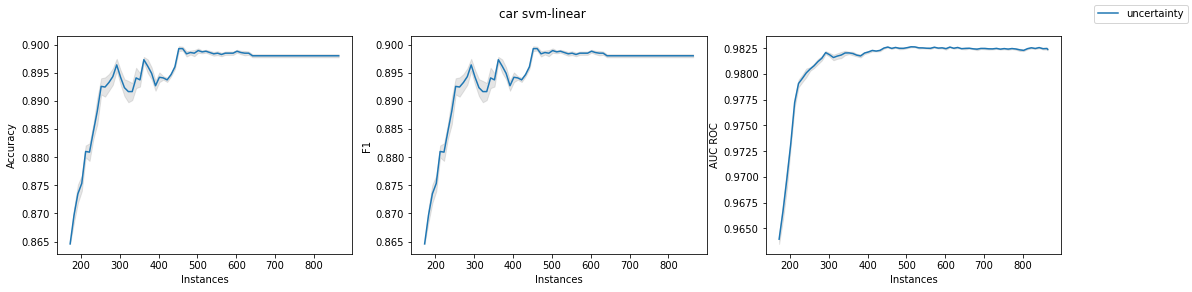

In [5]:
librun.plot(results)

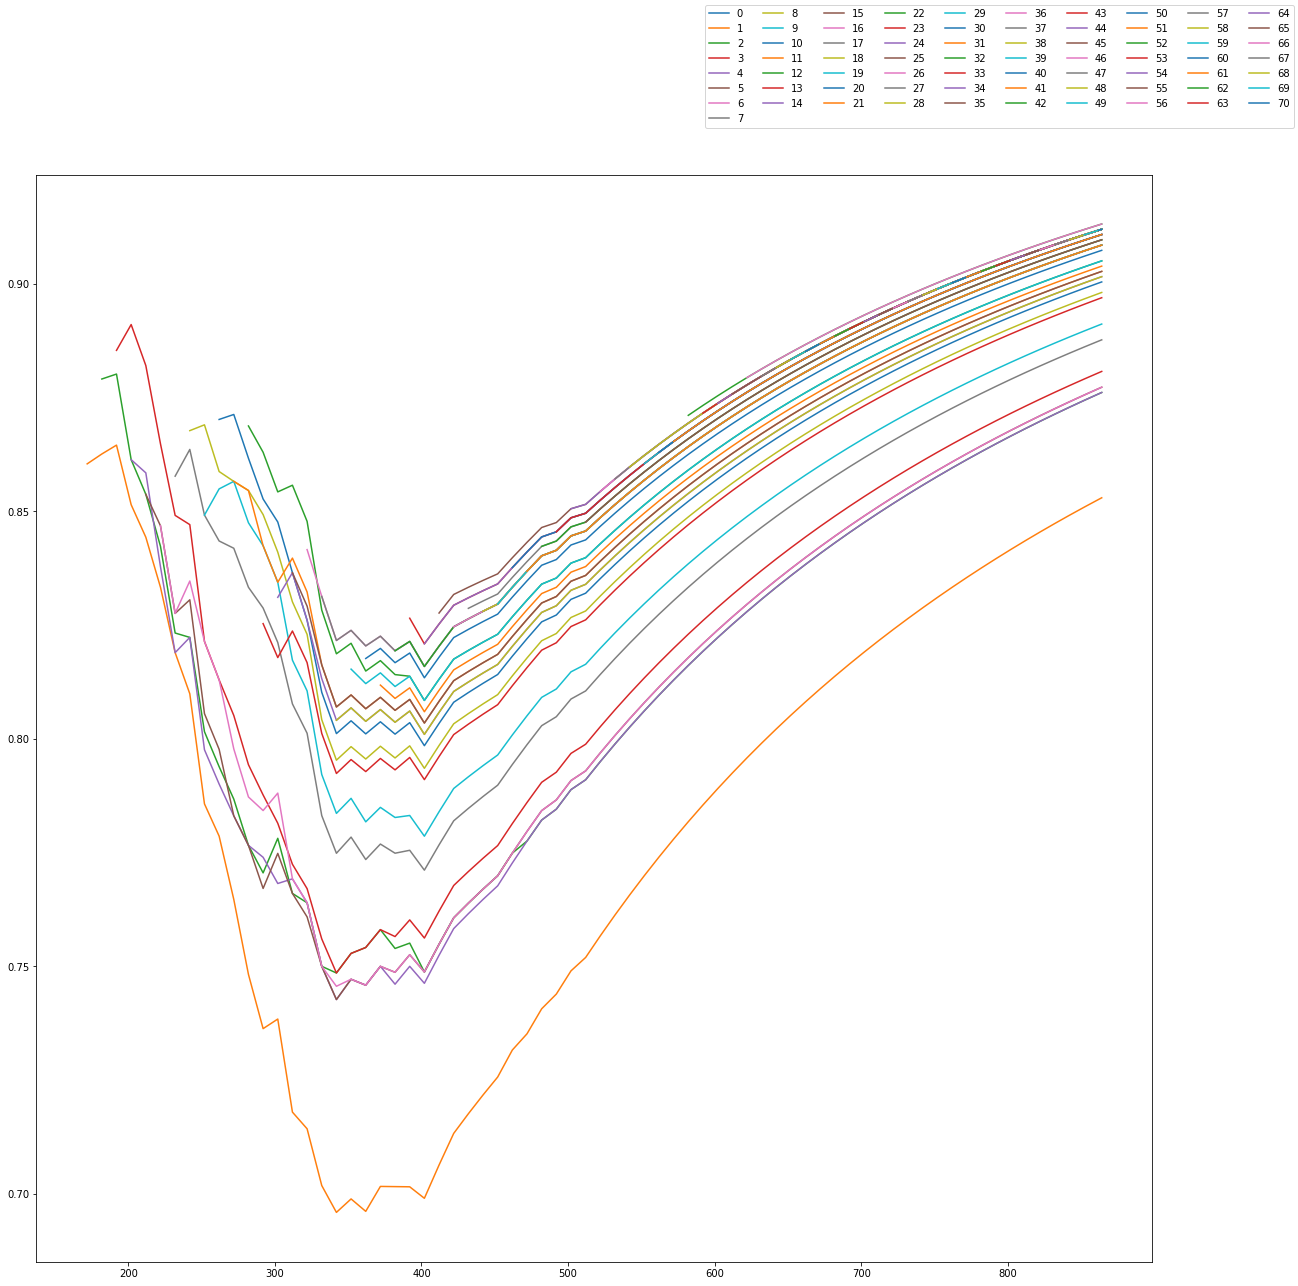

In [54]:
fig, ax = plt.subplots(1, figsize=(20,20))
for i, clf in enumerate(classifiers):
    x = []
    accuracy = []
    for clf2 in classifiers[i-1:]:
        x.append(clf2.X_training.shape[0])
        accuracy.append(clf.score(clf2.X_training, clf2.y_training))
    ax.plot(x, accuracy, label=i)
fig.legend(ncol=10)

## Past classifier performance on past labels

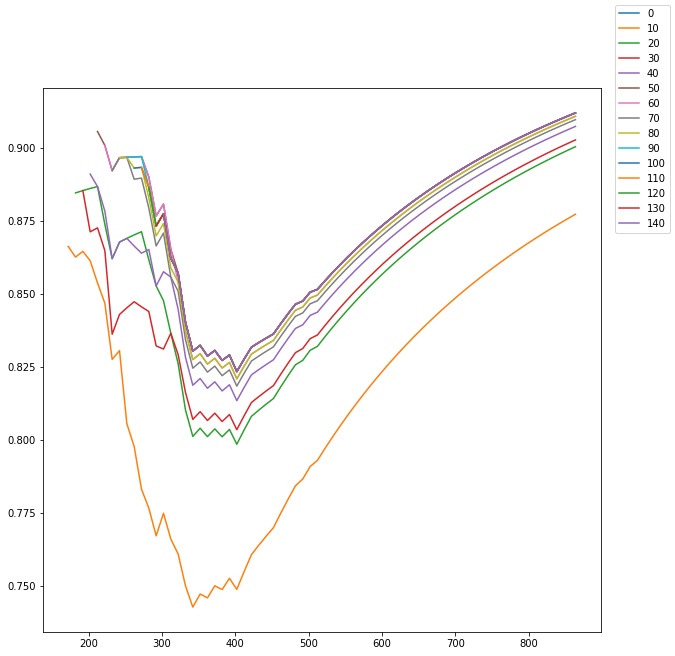

In [110]:
fig, ax = plt.subplots(1, figsize=(10,10))
xs = []
accuracies = []
for i, clf in enumerate(itertools.islice(classifiers, None, None, 5)):
    x = []
    accuracy = []
    for ii, clf2 in enumerate(classifiers[i-1:]):
        x.append(clf2.X_training.shape[0])
        accuracy.append(clf.score(clf2.X_training, clf2.y_training))
    ax.plot(x, accuracy, label=i*10)
    xs.append(x)
    accuracies.append(accuracy)
#xs = [np.mean(l)/len(l) for l in xs]
#accuracies = [np.mean(l) for l in accuracies]
#ax.plot(xs, accuracies)
fig.legend();

We can see a consistent pattern in the previous classifiers.

* Initially the active learning algorithm chooses informative instances, these instances are not known to the previous classifiers and so reduce their accuracy.
* Then the algorithm chooses insntances which are not necessarilly informative to it, but also are not known to the previous classifiers (this happens more later).
* Finally the algorithm has no choice but to choose uninformative instances. These are known to the first classifier and slowly make up a larger proportion of the total labelled pool,
  hence the performance of the first classifier increases.

## Derivatives

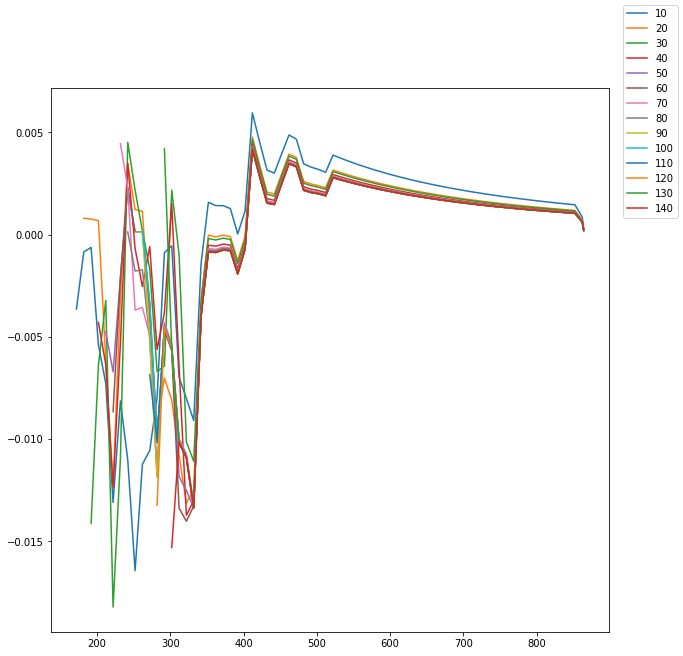

In [81]:
fig, ax = plt.subplots(1, figsize=(10,10))
for i, clf in enumerate(itertools.islice(classifiers, None, None, 5)):
    x = []
    accuracy = []
    for clf2 in classifiers[i-1:]:
        x.append(clf2.X_training.shape[0])
        accuracy.append(clf.score(clf2.X_training, clf2.y_training))
    if len(accuracy) > 1:
        ax.plot(x, np.gradient(accuracy), label=i*10)
fig.legend();

## Averaged derivatives?

864 [(864, 0.8518518518518519)]
172 [(172, 0.8604651162790697)]
182 [(182, 0.8626373626373627)]
192 [(192, 0.8645833333333334)]
202 [(202, 0.8514851485148515)]
212 [(212, 0.8443396226415094)]
222 [(222, 0.8333333333333334)]
232 [(232, 0.8189655172413793)]
242 [(242, 0.8099173553719008)]
252 [(252, 0.7857142857142857)]
262 [(262, 0.7786259541984732)]
272 [(272, 0.7647058823529411)]
282 [(282, 0.74822695035461)]
292 [(292, 0.7363013698630136)]
302 [(302, 0.7384105960264901)]
312 [(312, 0.717948717948718)]
322 [(322, 0.7142857142857143)]
332 [(332, 0.7018072289156626)]
342 [(342, 0.695906432748538)]
352 [(352, 0.6988636363636364)]
362 [(362, 0.6961325966850829)]
372 [(372, 0.7016129032258065)]
382 [(382, 0.7015706806282722)]
392 [(392, 0.701530612244898)]
402 [(402, 0.6990049751243781)]
412 [(412, 0.7063106796116505)]
422 [(422, 0.7132701421800948)]
432 [(432, 0.7175925925925926)]
442 [(442, 0.7217194570135747)]
452 [(452, 0.7256637168141593)]
462 [(462, 0.7316017316017316)]
472 [(472, 0.

IndexError: list index out of range

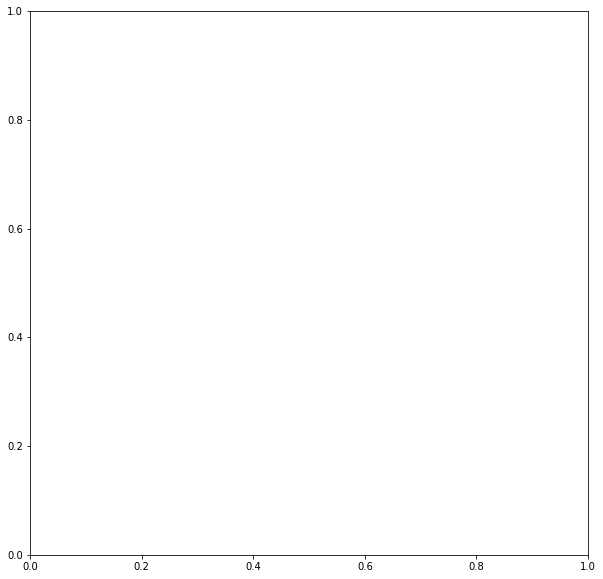

In [91]:
fig, ax = plt.subplots(1, figsize=(10,10))
pairs = []
for i, clf in enumerate(itertools.islice(classifiers, None, None, 5)):
    x = []
    accuracy = []
    for clf2 in classifiers[i-1:]:
        pairs.append((clf2.X_training.shape[0], clf.score(clf2.X_training, clf2.y_training)))
        
for x, g in itertools.groupby(pairs, key=lambda x: x[0]):
    print(x, list(g))
pts = np.array([(x, np.mean(list(l)[1])) for x, l in itertools.groupby(pairs, key=lambda x: x[0])])
print(pts)
ax.plot(pts[:,0], pts[:,1])
fig.legend();

## Difference between current and past classifier on whole dataset

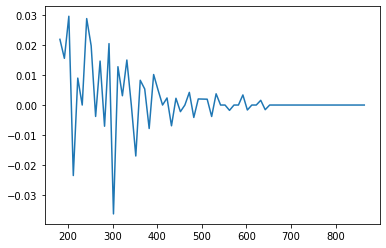

In [111]:
x = []
diffs = []
for clf, last in zip(classifiers, [None, *classifiers[:-1]]):
    if last is None:
        continue
    x.append(clf.X_training.shape[0])
    diffs.append(clf.score(clf.X_training, clf.y_training)-last.score(clf.X_training, clf.y_training))
plt.plot(x, diffs);

## Difference between current and first classifier on whole dataset

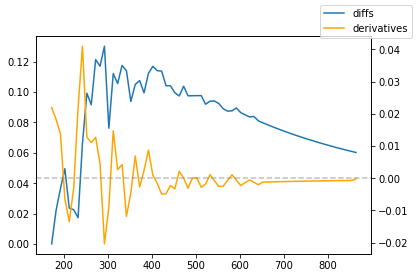

In [123]:
x = []
diffs = []
for clf in classifiers:
    last = classifiers[0]
    x.append(clf.X_training.shape[0])
    diffs.append(clf.score(clf.X_training, clf.y_training)-last.score(clf.X_training, clf.y_training))
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
ax.plot(x, diffs, label="diffs");
ax2.plot(x, np.gradient(diffs), c='orange', label="derivatives")
ax2.axhline(0, ls='--', c='grey', alpha=0.5)
fig.legend();

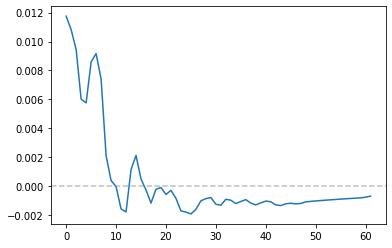

In [134]:
window_width = 10
cumsum_vec = np.cumsum(np.insert(np.gradient(diffs), 0, 0)) 
ma_grad_diffs = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(range(len(ma_grad_diffs)), ma_grad_diffs);
plt.axhline(0, ls='--', c='grey', alpha=0.5);

## On original accuracy graph (not smoothed)

In [144]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache()(car)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        #("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
    ],
    "models": [
        # isn't actually parsed to anything yet
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 10,
    }
}

In [145]:
results_conf = librun.run(matrix, force_cache=True)

In [152]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

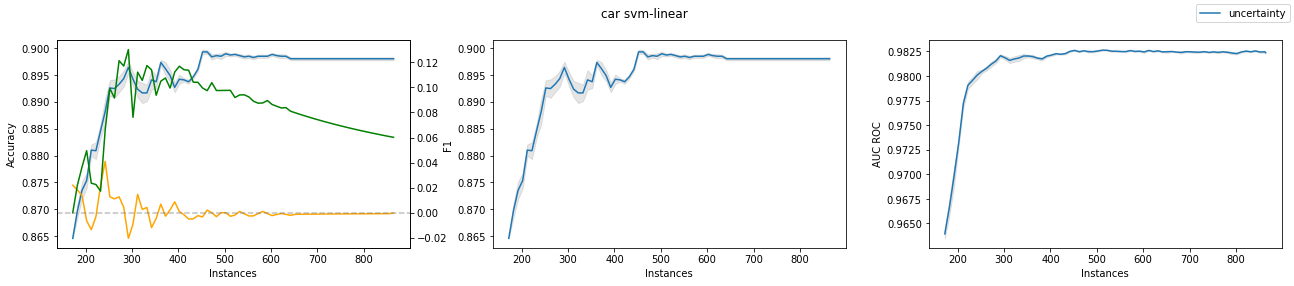

In [166]:
fig, axes = librun.plot(results_conf, ret=True)
ax2 = axes[0].twinx()
fig.tight_layout()
ax2.plot(x, np.gradient(diffs), color='orange', label="grad diffs")
ax2.plot(x, diffs, color='green', label="diffs")
ax2.axhline(0, ls='--', c='grey', alpha=0.5);

## Stop method 1

Difference between first classifier and current is less than `threshold`, and the last `len_gradient` gradients are $<0$.

In [177]:
threshold = 1e-1
len_gradient = 5
for i in range(10, len(diffs)):
    if diffs[i] < threshold and (np.gradient(diffs)[i-len_gradient:i] < 0).all():
        stop = x[i]
        break

In [178]:
stop

462

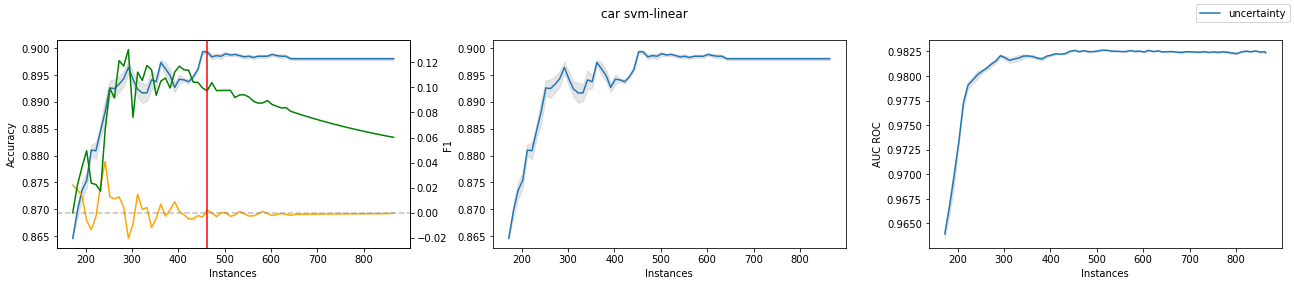

In [179]:
fig, axes = librun.plot(results_conf, ret=True)
ax2 = axes[0].twinx()
fig.tight_layout()
ax2.plot(x, np.gradient(diffs), color='orange', label="grad diffs")
ax2.plot(x, diffs, color='green', label="diffs")
ax2.axhline(0, ls='--', c='grey', alpha=0.5);
ax2.axvline(stop, color='red');

## Stop method 2

Absolute value of the derivative of the first classifier differences is below `threshold` for `n` iterations.

In [193]:
threshold = 1e-2
n = 10
for i in range(10, len(diffs)):
    if (np.abs(np.gradient(diffs)[i-n:i]) < threshold).all():
        stop = x[i]
        break

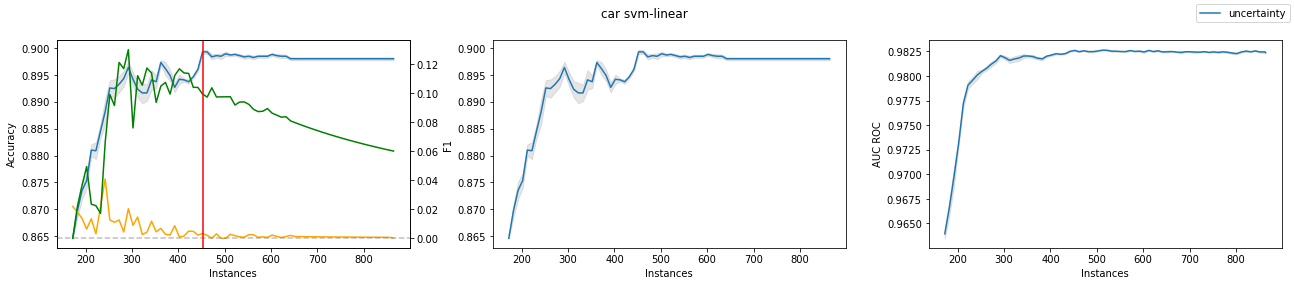

In [194]:
fig, axes = librun.plot(results_conf, ret=True)
ax2 = axes[0].twinx()
fig.tight_layout()
ax2.plot(x, np.abs(np.gradient(diffs)), color='orange', label="grad diffs")
ax2.plot(x, diffs, color='green', label="diffs")
ax2.axhline(0, ls='--', c='grey', alpha=0.5);
ax2.axvline(stop, color='red');

In [7]:
def diffs(classifiers, metric=metrics.accuracy_score, nth='previous'):
    x = []
    diffs = []
    for clf, last in zip(classifiers, [None, *classifiers[:-1]]):
        if last is None:
            continue
        if nth is int:
            last = classifiers[nth]
        x.append(clf.X_training.shape[0])
        
        if metric == roc_auc_score:
            if len(np.unique(clf.y_training)) > 2 or len(clf.y_training.shape) > 1:
                diffs.append(metric(clf.y_training, clf.predict_proba(clf.X_training), multi_class="ovr")-metric(clf.y_training, last.predict_proba(clf.X_training), multi_class="ovr"))
            else:
                diffs.append(metric(clf.y_training, clf.predict_proba(clf.X_training)[:,1])-metric(clf.y_training, last.predict_proba(clf.X_training)[:,1]))
        else:
            diffs.append(metric(clf.y_training, clf.predict(clf.X_training))-metric(clf.y_training, last.predict(clf.X_training)))
    return x, diffs

def grads(classifiers, metric=metrics.accuracy_score, nth='previous'):
    x, _diffs = diffs(classifiers, metric, nth)
    return x, np.gradient(_diffs)

def acc(classifiers, metric=metrics.accuracy_score, nth=0):
    x = []
    diffs = []
    if isinstance(nth, int):
        start = nth+1 
    elif nth == 'last':
        start = 1
    else:
        start = 0
    for i, clf in enumerate(classifiers[start:]):
        #if nth is int and i < nth:
        #    x.append(clf.X_training.shape[0])
        #    diffs.append(np.inf)
        x.append(clf.X_training.shape[0])
        
        if clf.y_training.shape[0] <= 10:
            diffs.append(np.inf)
            continue
        size = 10
        if isinstance(nth, int):
            pclf = classifiers[nth]
        elif nth == 'last':
            pclf = classifiers[i-1]
        else:
            pclf = classifiers[0]
            
        if metric == roc_auc_score:
            if len(np.unique(clf.y_training)) > 2 or len(clf.y_training.shape) > 1:
                diffs.append(metric(clf.y_training[:-size], pclf.predict_proba(clf.X_training[:-size]), multi_class="ovr"))
            else:
                diffs.append(metric(clf.y_training[:-size], pclf.predict_proba(clf.X_training[:-size])[:,1]))
        else:
            diffs.append(metric(clf.y_training[:-size], pclf.predict(clf.X_training[:-size])))
    return x, diffs
    
def stop_criterion2(classifiers, threshold=1e-2, n=10, metric=metrics.accuracy_score):
    x, _diffs = diffs(classifiers, metric)
    _grads = np.gradient(_diffs)
    for i in range(10, len(_diffs)):
        if (np.abs(_diffs[i-n:i]) < threshold).all():
            return x[i], x, _grads
    return np.inf, x, _grads

def stop_criterion3(classifiers, threshold=1e-2, n=10, metric=metrics.accuracy_score):    
    x, _diffs = diffs(classifiers, metric)
    _grads = np.gradient(_diffs)
    for i in range(10, len(_diffs)):
        if (np.abs(_diffs[i-n:i]) < threshold).all():
            return x[i], x, _grads
    return np.inf, x, _grads

def no_ahead_grad(x):
    """
    Compute a gradient across x, ensuring that no values ahead of the current are used for the
    gradient calculation.
    """
    return [np.inf,np.inf, *[np.gradient(x[:i])[-1] for i in range(2, len(x))]]

def stop_criterion4(classifiers, eps=0, n=3, metric=metrics.accuracy_score, nth='first'):
    """
    Last n grad acc (first) were positive.
    """
    x, accs = acc(classifiers, nth=nth)
    #grad_accs = np.gradient(accs)
    grad_accs = no_ahead_grad(accs)
    for i in range(n, len(grad_accs)):
        if all(grad_accs[i-x]>eps for x in range(n)):
            return x[i], x

In [4]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        #("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1,
        "ret_classifiers": True
    }
}

In [313]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

In [5]:
results2 = librun.run(matrix)

In [6]:
results2_plots = [result[0] for result in results2]
classifiers2 = [result[1] for result in results2]
classifiers2 = [clf[0] for clf in classifiers2]

In [7]:
from scipy.interpolate import interp1d

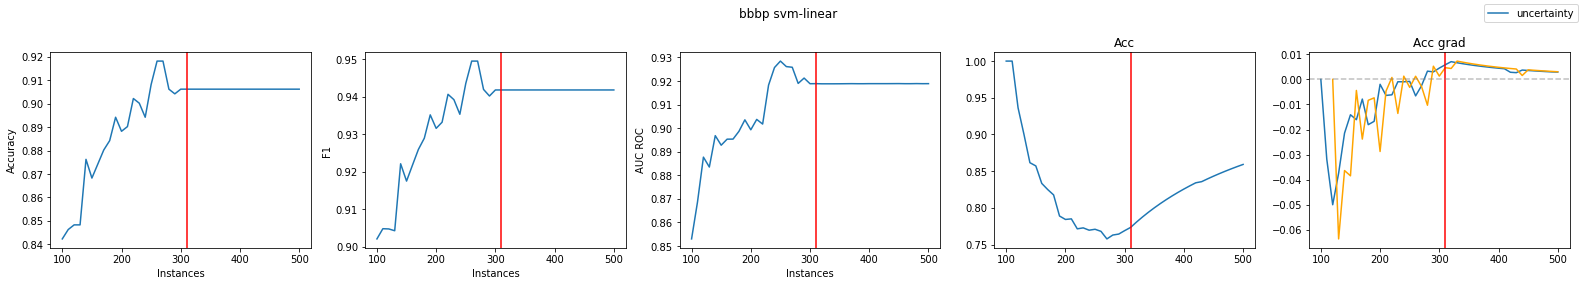

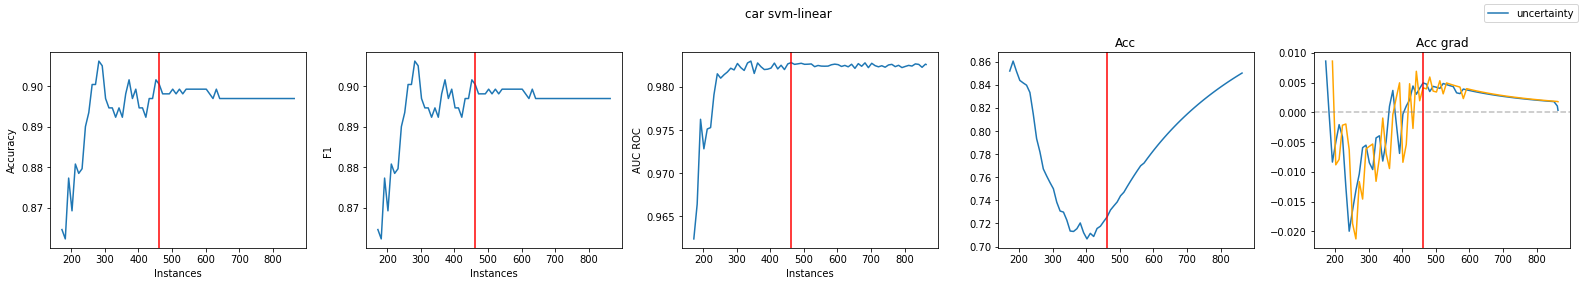

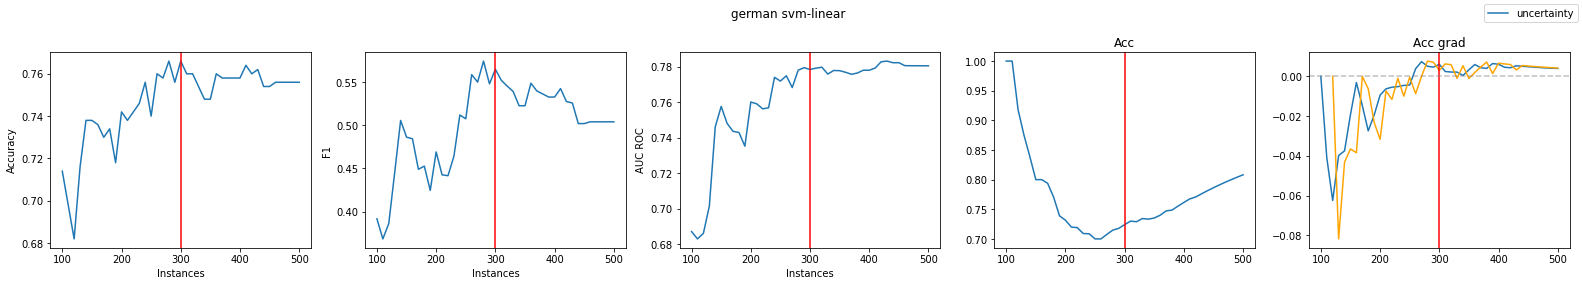

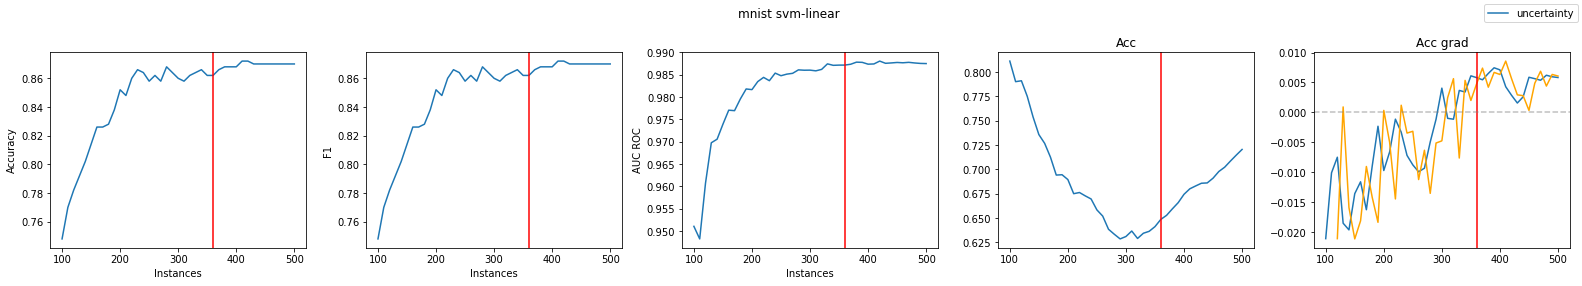

In [10]:
figaxes = librun.plot(results2_plots, ret=True, extra=2, figsize=(22,4))
for i, (fig, ax) in enumerate(figaxes):
    stop, x, = stop_criterion4(classifiers2[i], )#metric=metrics.roc_auc_score)
    gradsx, _grads = grads(classifiers2[i])
    dx, _diffs = diffs(classifiers2[i])
    accx, _acc = acc(classifiers2[i], nth='first', )#metric=metrics.roc_auc_score)
    #ax[-4].set_title("Diffs")
    #ax[-4].plot(dx, np.abs(_diffs))
    #ax[-3].set_title("Grads")
    #ax[-3].plot(gradsx, np.abs(_grads))
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, np.abs(_acc))
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, np.gradient(_acc))
    ax[-1].plot(accx, no_ahead_grad(_acc), color='orange')
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

## Does a smaller initial size still work?

In [21]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        #("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 1,
        "ret_classifiers": True,
        "ensure_y": True
    }
}

In [19]:
X,y=car()

In [20]:
y

array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'good', 'vgood'],
      dtype=object)

In [22]:
results3 = librun.run(matrix)

In [23]:
results3_plots = [result[0] for result in results3]
classifiers3 = [result[1] for result in results3]
classifiers3 = [clf[0] for clf in classifiers3]

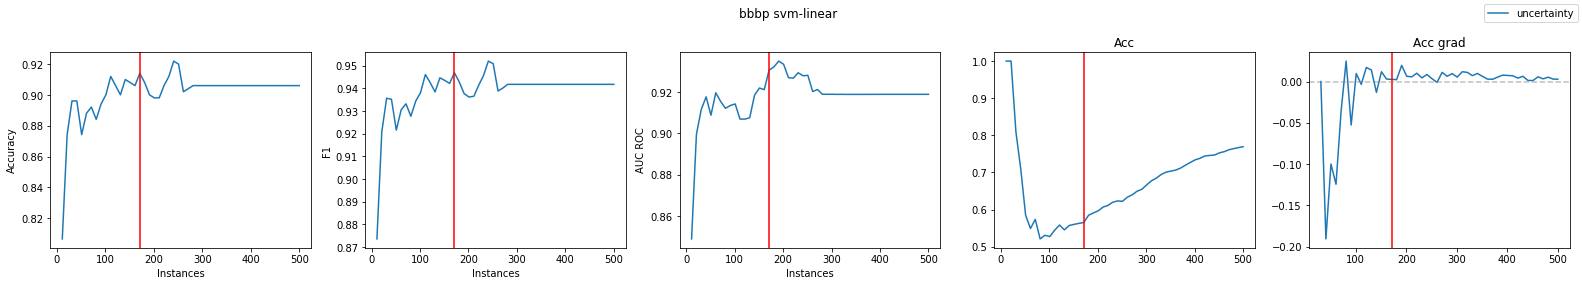

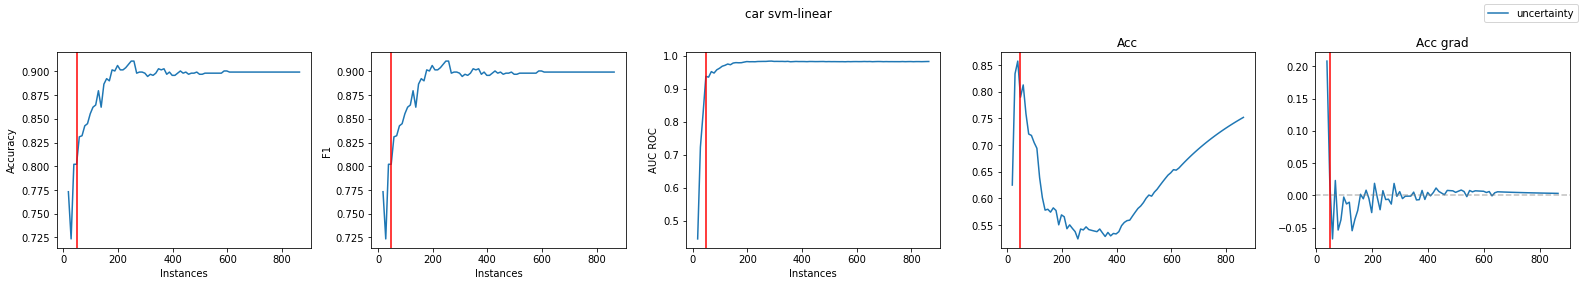

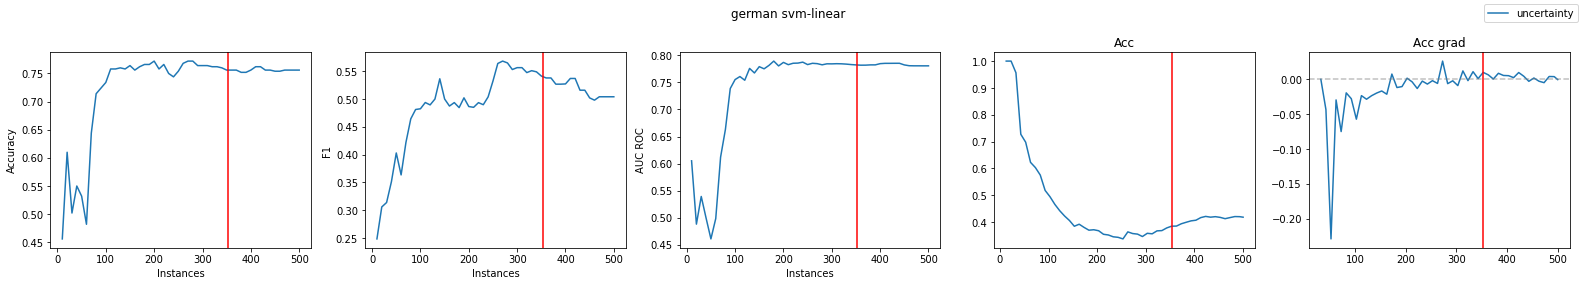

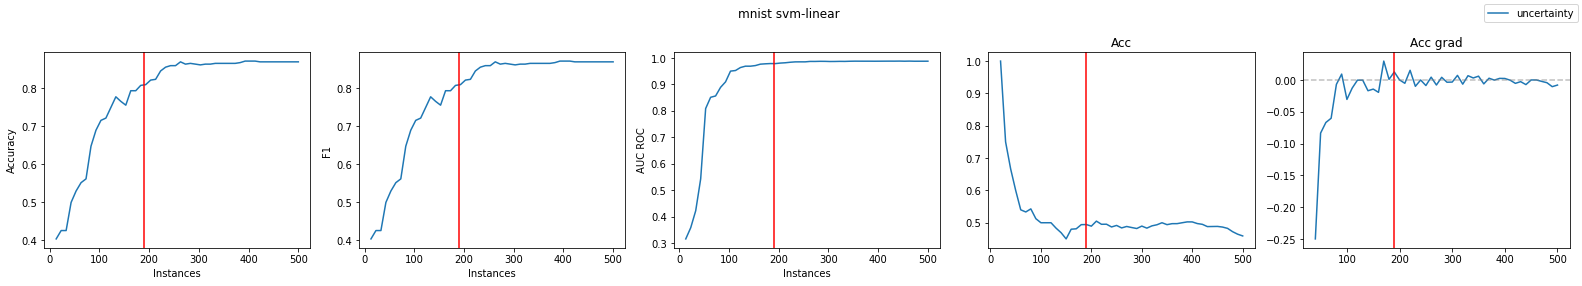

In [51]:
figaxes = librun.plot(results3_plots, ret=True, extra=2, figsize=(22,4))
for i, (fig, ax) in enumerate(figaxes):
    stop, x, = stop_criterion4(classifiers3[i], )#metric=metrics.roc_auc_score)
    gradsx, _grads = grads(classifiers3[i])
    dx, _diffs = diffs(classifiers3[i])
    accx, _acc = acc(classifiers3[i], nth='first', )#metric=metrics.roc_auc_score)
    #ax[-4].set_title("Diffs")
    #ax[-4].plot(dx, np.abs(_diffs))
    #ax[-3].set_title("Grads")
    #ax[-3].plot(gradsx, np.abs(_grads))
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, np.abs(_acc))
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

First classifier isn't great here, what about a later one?

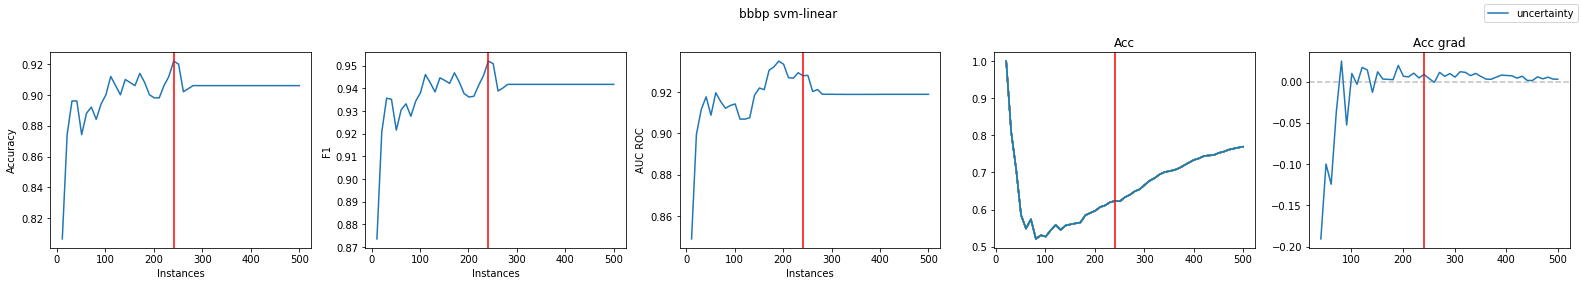

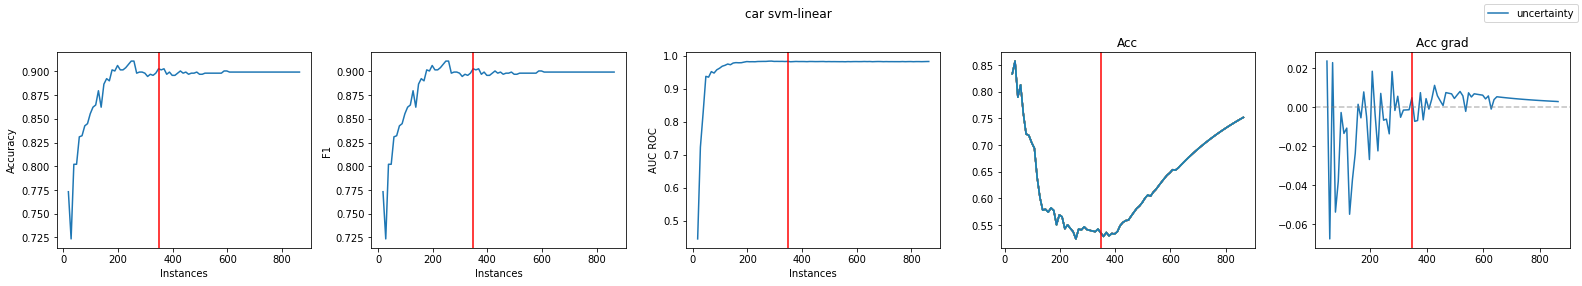

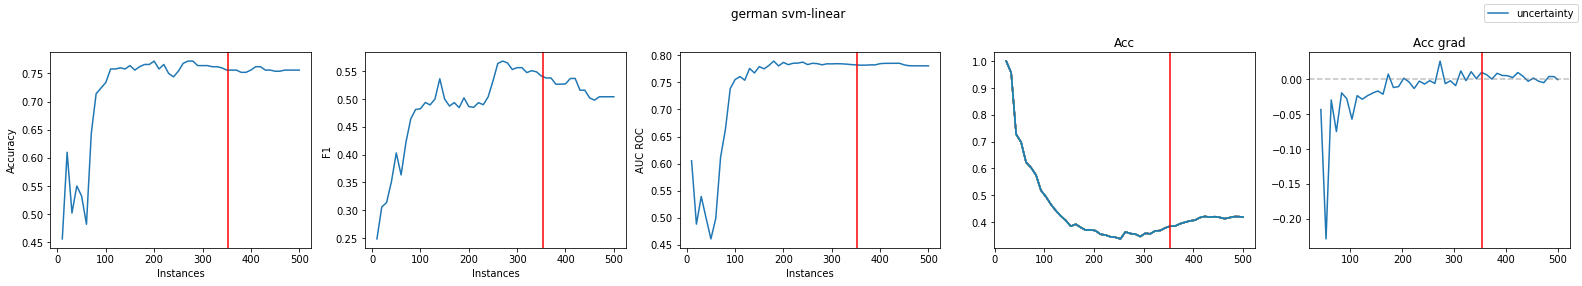

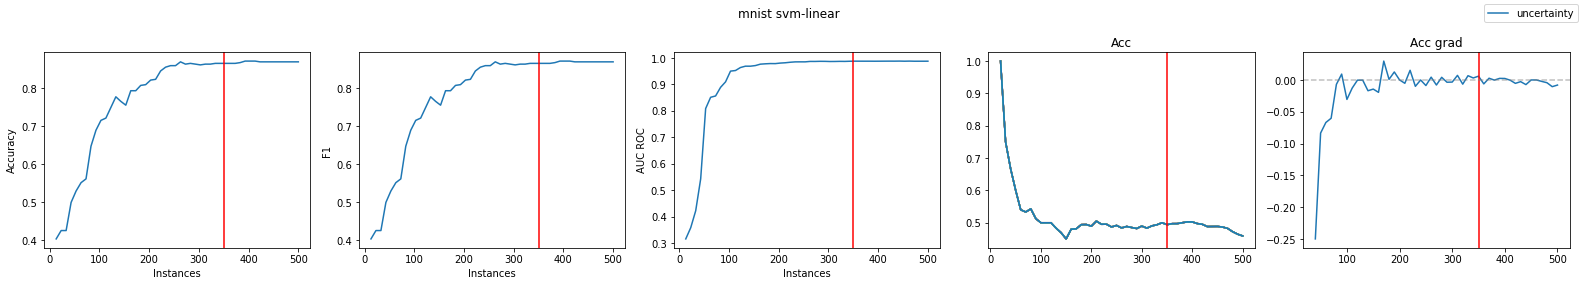

In [53]:
figaxes = librun.plot(results3_plots, ret=True, extra=2, figsize=(22,4))
for i, (fig, ax) in enumerate(figaxes):
    stop, x, = stop_criterion4(classifiers3[i], nth=2)#metric=metrics.roc_auc_score)
    gradsx, _grads = grads(classifiers3[i])
    dx, _diffs = diffs(classifiers3[i])
    accx, _acc = acc(classifiers3[i], nth=0, )#metric=metrics.roc_auc_score)
    #ax[-4].set_title("Diffs")
    #ax[-4].plot(dx, np.abs(_diffs))
    #ax[-3].set_title("Grads")
    #ax[-3].plot(gradsx, np.abs(_grads))
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, _acc)
    for nth in [1,2,3,4,5,6,7,8,9,10]:
        accxn, _accn = acc(classifiers3[i], nth=0, )
        ax[-2].plot(accxn, _accn)
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

In [89]:
reload(libadversarial); from libadversarial import uncertainty_stop 

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 1,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True
    }
}

In [3]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    "uncertainty_average",
    "uncertainty_min",
    "n_support",
    # this is the only stopping metric which has significant runtime collection cost
    "expected_error"
]

In [5]:
results4 = librun.run(matrix, metrics=capture_metrics, force_cache=True)
results4_plots = [result[0] for result in results4]
classifiers4 = [result[1] for result in results4]
classifiers4 = [clf[0] for clf in classifiers4]

KeyError: 'expected_error'

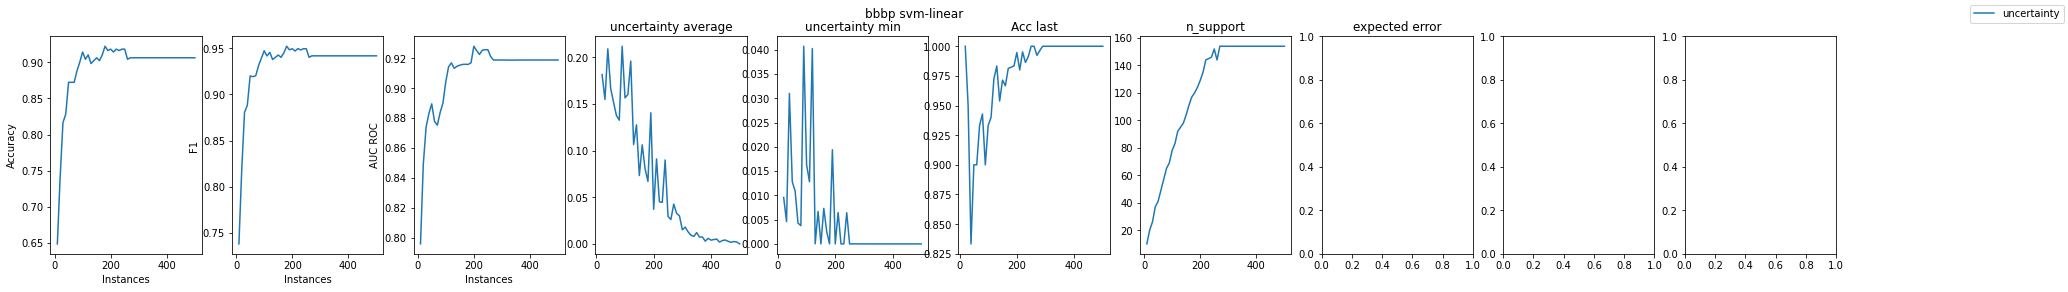

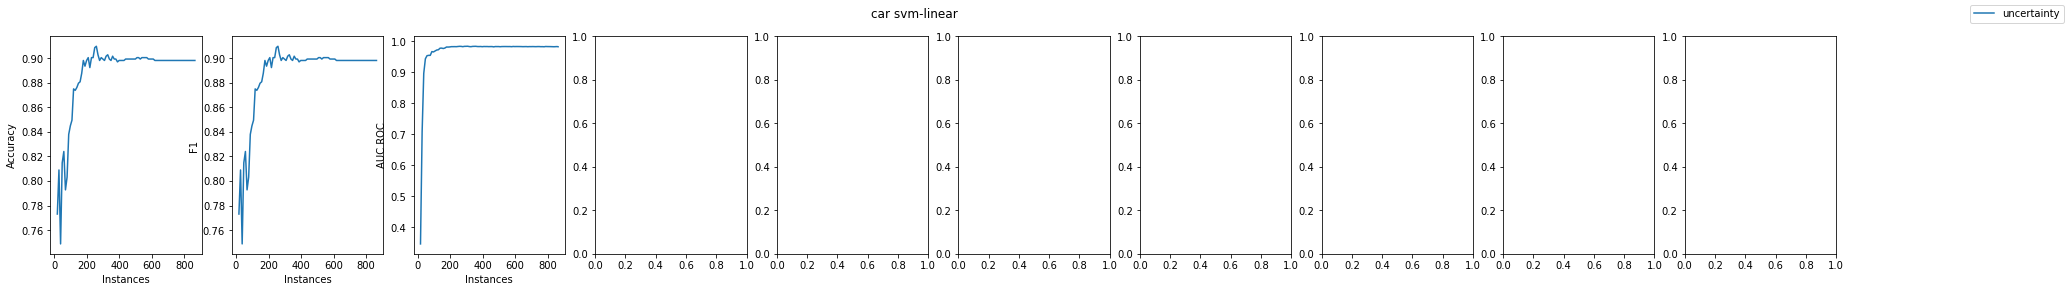

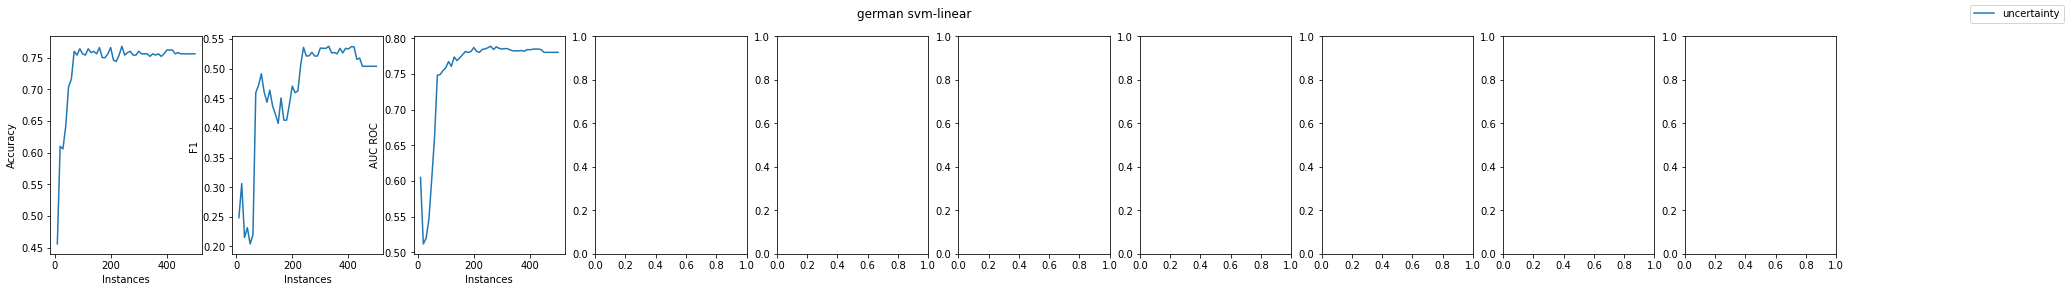

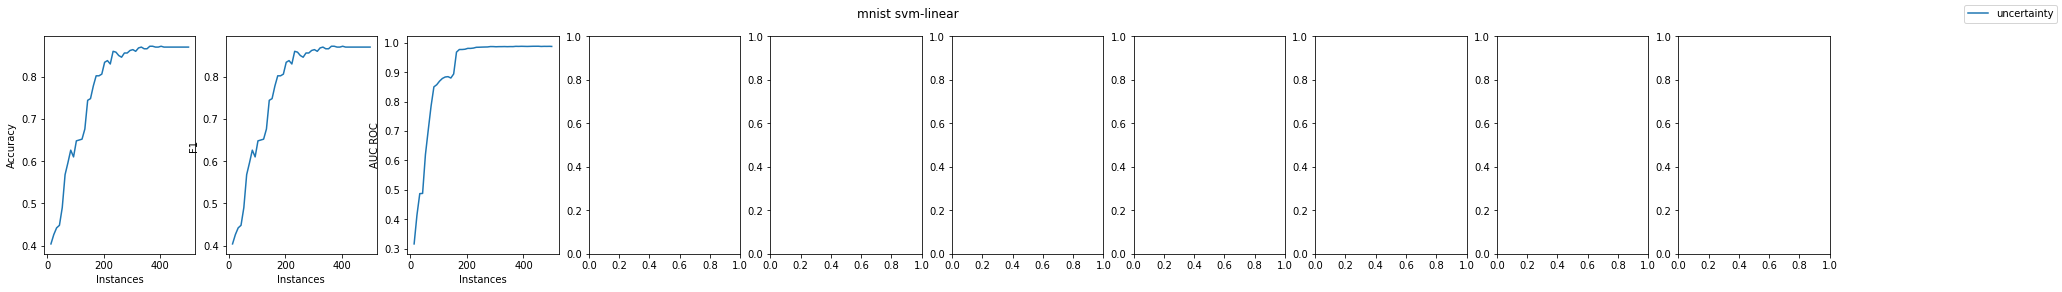

In [8]:
figaxes = librun.plot(results4_plots, ret=True, extra=7, figsize=(32,4))
for i, (fig, ax) in enumerate(figaxes):
    stop, x, = stop_criterion4(classifiers4[i], nth=2)#metric=metrics.roc_auc_score)
    gradsx, _grads = grads(classifiers4[i])
    dx, _diffs = diffs(classifiers4[i])
    accx, _acc = acc(classifiers4[i], nth=0, )#metric=metrics.roc_auc_score)
    ax[-7].set_title("uncertainty average")
    ax[-7].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_average'])
    ax[-6].set_title("uncertainty min")
    ax[-6].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_min'])
    
    ax[-5].set_title("Acc last")
    ax[-5].plot(*acc(classifiers4[i], nth='last', ))
    
    ax[-4].set_title("n_support")
    ax[-4].plot(results4_plots[i][1]['x'], results4_plots[i][1]['n_support'])
    
    ax[-3].set_title("expected error")
    ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['expected_error'])
    
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, _acc)
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

## Does the saturation from the measurement process matter?

In [ ]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("mnist", lambda: lru_cache()(mnist)(dataset_size=70000)),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 70000,
        "labelled_size": 10,
        "test_size": 1000
        "n_runs": 1,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "stop_function": lambda learner: learner.y_training.shape[0] >= 1000
    }
}

In [ ]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    "uncertainty_average",
    "uncertainty_min",
    "n_support",
]

In [ ]:
results4 = librun.run(matrix, metrics=capture_metrics, force_run=True)
results4_plots = [result[0] for result in results4]
classifiers4 = [result[1] for result in results4]
classifiers4 = [clf[0] for clf in classifiers4]